This notebook briefly demonstrates the use of linear parameter varying (LPV) models in formulating and solving an open-loop optimal control (OLOC) problem.

The goal of the notebook is to show the key inputs and outputs from solving an open-loop optimal control problem, whose chief objective is to maximize the power generated for a given wind input subject to the dynamics of the underlying system.
For more information regarding the problem formulation, please refer to Reference [1].

An LPV modeling scheme is used to approximate the dynamics of the floating offshore wind turbine.
More details regarding the LPV modeling scheme can be found in the notebook `review_LPVmodeling.ipynb`, which is available as part of this example.

The function `DTQPy_oloc.py` is used to formulate and solve the problem. 

The open-source tool DTQPy is used to formulate and solve the problem. DTQPy uses the direct-transcription approach to solve the problem.
Please refer to the function for more details on formulating the problem.


For additional details regarding the LPV modeling scheme and the problem formulation, please refer to:

[1] A. K. Sundarrajan, Y. H. Lee, J. T. Allison, D. S. Zalkind, D. R. Herber. 'Open-loop control co-design of semisubmersible floating offshore wind turbines using linear parameter-varying models.' (to appear) ASME Journal of Mechanical Design, 146(4), p. 041704, Apr 2024. doi: https://doi.org/10.1115/1.4063969

For more information regarding the direct-transcription method to solve OLOC and CCD problems, please refer to:

[2]. James T. Allison, Tinghao Guo, Zhi Han. 'Co-Design of an Active Suspension Using Simultaneous Dynamic Optimization.' ASME Journal of Mechanical Design, Vol. 136, No. 8, p. 081003, 2014. doi: 10.1115/1.4027335

Please reach out to Athul.Sundarrajan@colostate.edu and Daniel.Herber@colostate.edu for more information and clarifications.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import mat4py

import pyoptsparse

In [2]:
# import linear turbine pkl file
pkl_file = 'LinearTurbine.pkl'

with open(pkl_file,'rb') as handle:
    LinearTurbine = pickle.load(handle)


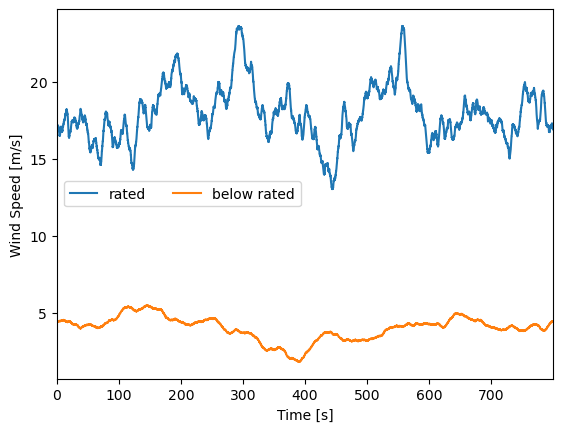

In [16]:
# load disturbance
dist_file = 'level2disturbance.mat'

dist = mat4py.loadmat(dist_file)
wind = np.array(dist['Wind'])

wind = wind.T
np.shape(wind)
time = wind[0,:]
t0 = time[0]; tf = time[-1]
wind_rated = wind[8,:]
wind_br = wind[1,:]

# plot wind speed profile
fig,ax = plt.subplots(1)

ax.plot(time,wind_rated,label = 'rated')
ax.plot(time,wind_br,label = 'below rated')
ax.set_xlim([t0,tf])
ax.set_xlabel('Time [s]')
ax.set_ylabel('Wind Speed [m/s]')
ax.legend(ncol = 2)

# The goal is to find the optimal generator torque and blade pitch for the following wind speed profile
disturbance_rated = {'Time': time, 'Wind': wind_rated}
disturbance_br = {'Time': time, 'Wind': wind_br}

In [10]:
# dtqp options
dtqp_options = {'nt':1000, 'tolerance':1e-5,'function':'ipopt','maxiters':5000}


# consraints
constraints = {'ED Platform pitch tilt rotation DOF (internal DOF index = DOF_P), rad': [-np.inf,np.deg2rad(10)],
              'ED First time derivative of Variable speed generator DOF (internal DOF index = DOF_GeAz), rad/s'
        : [-np.inf,(1 + 0.2) * 0.7853192931562493]}

In [11]:
# solve the OLOC problem

from weis.dtqpy.DTQPy_oloc import DTQPy_oloc

# hack to get argparse to work with jupyter notebooks
import sys
sys.argv = ['']

# DTQPy_oloc formulates the optimal control problem
# The objective is to maximize the generator power which is calculated as gen_torque * gen_speed
# Please refer to Ref. [1] for more details
T,U,X,Y = DTQPy_oloc(LinearTurbine, disturbance_rated, constraints, dtqp_options)

/home/athulsun/anaconda3/envs/weis-env/lib/python3.11/site-packages/pyoptsparse/pyOpt_constraint.py:300: UserWarning: Using scipy.sparse matrices with pyOptSparse is VERY STRONGLY discouraged. Please use the simplified pyOptSparse format which allows for fixed sparsity structure and explicit zeros in the matrix. There is no way to guarantee a fixed sparsity structure with scipy matrices which is what the underlying optimizers require. Using scipy.sparse matrices may cause unexpected errors.
  self.jac[dvGroup] = convertToCOO(self.jac[dvGroup])


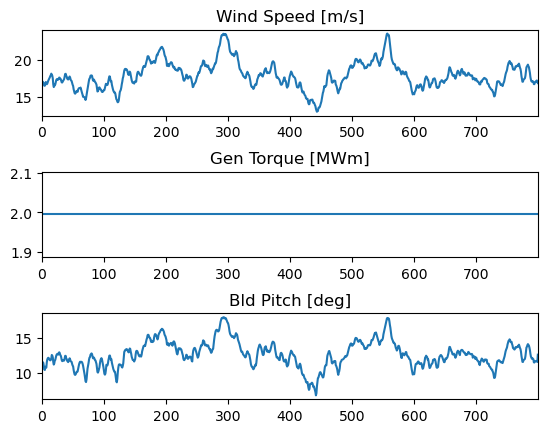

In [12]:
# plot
fig, ((ax1,ax2,ax3)) = plt.subplots(3,1,)

# wind
ax1.plot(T,U[:,0])
ax1.set_title('Wind Speed [m/s]')
ax1.set_xlim([t0,tf])

# torue
ax2.plot(T,U[:,1]/1e+07)
#ax2.set_ylim([1.8,2])
ax2.set_title('Gen Torque [MWm]')
ax2.set_xlim([t0,tf])

# blade pitch
ax3.plot(T,np.rad2deg(U[:,2]))
#ax3.set_ylim([0.2, 0.3])
ax3.set_title('Bld Pitch [deg]')
ax3.set_xlim([t0,tf])

fig.subplots_adjust(hspace = 0.65)

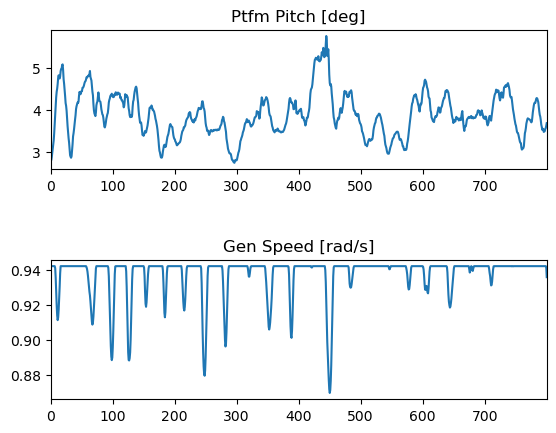

In [13]:
# plot states
fig2, ((ax1,ax2)) = plt.subplots(2,1)

# PtfmPitch
ax1.plot(T,np.rad2deg(X[:,0]))
ax1.set_xlim([t0,tf])
ax1.set_title('Ptfm Pitch [deg]')

# FenSpeed
ax2.plot(T,X[:,4])
ax2.set_xlim([t0,tf])
ax2.set_title('Gen Speed [rad/s]')

fig2.subplots_adjust(hspace = 0.65)

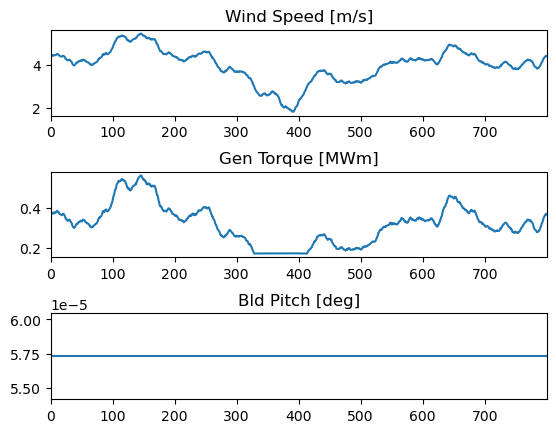

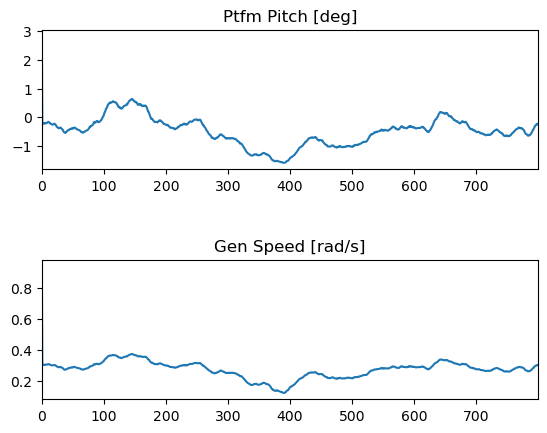

In [17]:
# Solve an OLOC problem for the below rated wind profile
T,U,X,Y = DTQPy_oloc(LinearTurbine, disturbance_br, constraints, dtqp_options)

# plot
fig, ((ax1,ax2,ax3)) = plt.subplots(3,1,)

# wind
ax1.plot(T,U[:,0])
ax1.set_title('Wind Speed [m/s]')
ax1.set_xlim([t0,tf])

# torue
ax2.plot(T,U[:,1]/1e+07)
#ax2.set_ylim([1.8,2])
ax2.set_title('Gen Torque [MWm]')
ax2.set_xlim([t0,tf])

# blade pitch
ax3.plot(T,np.rad2deg(U[:,2]))
#ax3.set_ylim([0.2, 0.3])
ax3.set_title('Bld Pitch [deg]')
ax3.set_xlim([t0,tf])

fig.subplots_adjust(hspace = 0.65)

# plot states
fig2, ((ax1,ax2)) = plt.subplots(2,1)

# PtfmPitch
ax1.plot(T,np.rad2deg(X[:,0]))
ax1.set_xlim([t0,tf])
ax1.set_title('Ptfm Pitch [deg]')

# FenSpeed
ax2.plot(T,X[:,4])
ax2.set_xlim([t0,tf])
ax2.set_title('Gen Speed [rad/s]')

fig2.subplots_adjust(hspace = 0.65)